<h1>Preprocess</h1>

In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv('data/challenge_set.csv')

challenge_set_df = data_df.loc[:, ['adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 'wtc', 'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'tow']]

In [3]:
display(challenge_set_df)

,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow
0,EGLL,GB,EICK,IE,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.000000
1,LEBL,ES,KMIA,US,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,570,13,4193,185441.000000
2,ESSA,SE,KORD,US,A333,H,8be5c854fd664bcb97fb543339f74770,554,15,3770,230396.000000
3,LSZH,CH,KPHL,US,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,497,11,3607,157615.000000
4,EIDW,IE,EGLL,GB,A21N,M,a73f82288988b79be490c6322f4c32ed,55,14,305,70318.447226
...,...,...,...,...,...,...,...,...,...,...,...
369008,LFPG,FR,KMIA,US,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,545,21,4046,163438.000000
369009,LTFM,TR,EDDB,DE,A21N,M,6351ec1b849adacc0cbb3b1313d8d39b,158,25,946,78707.000000
369010,EDDL,DE,EIDW,IE,A320,M,a73f82288988b79be490c6322f4c32ed,99,11,522,62942.750000
369011,LFPG,FR,EIDW,IE,A21N,M,a73f82288988b79be490c6322f4c32ed,84,12,466,72611.161024


In [4]:
label_encoders = {}
for column in ['adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 
                'wtc', 'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'tow']:
    le = LabelEncoder()
    challenge_set_df[column] = le.fit_transform(challenge_set_df[column])
    label_encoders[column] = le
    print("Label encoded:", column)
    print()

Label encoded: adep

Label encoded: country_code_adep

Label encoded: ades

Label encoded: country_code_ades

Label encoded: aircraft_type

Label encoded: wtc

Label encoded: airline

Label encoded: flight_duration

Label encoded: taxiout_time

Label encoded: flown_distance

Label encoded: tow



In [5]:
display(challenge_set_df)

,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow
0,67,36,76,33,4,1,20,53,18,296,2142
1,210,32,161,76,18,0,10,562,13,3876,9111
2,133,86,164,76,7,0,18,546,15,3453,11710
3,328,19,165,76,21,0,10,489,11,3290,7136
4,89,43,55,26,1,1,20,47,14,280,4610
...,...,...,...,...,...,...,...,...,...,...,...
369008,245,35,161,76,21,0,10,537,21,3729,7446
369009,374,94,13,18,1,1,14,150,25,921,5618
369010,29,26,77,33,4,1,20,91,11,497,3461
369011,245,35,77,33,1,1,20,76,12,441,4954


In [6]:
for column in challenge_set_df.columns:
    print(f"Processing {column}")
    for v in challenge_set_df[column].values:
        if type(v) != np.int64:
            print("Not valud Value found:", v, ", having type:", type(v))

        if v < 0:
            print("Value:", v, " is smaller than 0")

        if np.isinf(v):
            print("Value:", v, "is infinite")

Processing adep
Processing country_code_adep
Processing ades
Processing country_code_ades
Processing aircraft_type
Processing wtc
Processing airline
Processing flight_duration
Processing taxiout_time
Processing flown_distance
Processing tow


<h1>Prepare for Grid Search</h1>

In [7]:
# Pick up features from dataset
features = challenge_set_df[['adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 'wtc', 'airline']]

# Pick up target from dataset
target = challenge_set_df['tow']

# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=123)

# Function to print the best parameters and best RMSE score after tunning
def print_model_score(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (Negative Mean Squared Error):", grid_search.best_score_)

<h1>Grid Search using DecisionTreeRegressor()</h1>

In [8]:
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [1, 2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'sqrt'],
    'criterion': ['squared_error', 'friedman_mse'],
    'ccp_alpha': [0, 0.001, 0.005]
}

# Set up GridSearchCV with custom scoring
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=123), 
    param_grid=param_grid, 
    scoring=rmse_scorer, 
    cv=cv_strategy, 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(features, target)

print_model_score(grid_search)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameters: {'ccp_alpha': 0.001, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best Score (Negative Mean Squared Error): -442.7090120790332


<h1>Grid Search using RandomForestRegressor()</h1>

In [9]:
param_grid = {
    'ccp_alpha': [0.001], 
    'criterion': ['squared_error'], 
    'max_depth': [30], 
    'max_features': [None], 
    'min_samples_leaf': [2], 
    'min_samples_split': [8],
    'n_estimators': [20, 40, 60, 80, 100],
    'bootstrap': [True, False]
}

# Set up GridSearchCV with custom scoring
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=123), 
    param_grid=param_grid, 
    scoring=rmse_scorer, 
    cv=cv_strategy, 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(features, target)

print_model_score(grid_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.001, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}
Best Score (Negative Mean Squared Error): -440.13433848849854


<h1>Predicting using the tunned parameters of RandomForestRegressor()</h1>

In [10]:
# Function to plot an example prediction with the tunned parameters
def plot_rmse(observed, predicted, show_error=False):
    # Calculate errors
    errors = observed - predicted
    squared_errors = errors**2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plot the observed and predicted values
    plt.plot(observed, 'o-', label='Observed Values')
    plt.plot(predicted, 'o-', label='Predicted Values')
    
    # Plot the errors
    for i in range(len(observed)):
        plt.plot([i, i], [observed[i], predicted[i]], 'r--')
        if show_error:
            plt.text(i, (observed[i] + predicted[i]) / 2, f'{errors[i]:.1f}', ha='right', color='red')
    
    # Adding labels and title
    plt.xlabel('Data Points')
    plt.ylabel('Values')
    plt.title('Visualizing RMSE Calculation')
    plt.legend()
    plt.grid(True)
    
    # Show RMSE in the plot
    plt.text(1.5, max(observed) - 1, f'RMSE = {rmse:.3f}', fontsize=12, color='blue')

    plt.xticks([])
    plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=True)

model = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.001,
    criterion='squared_error',
    max_depth=30,
    max_features=None,
    min_samples_leaf=2,
    min_samples_split=8,
    n_estimators=100,
    random_state=123
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

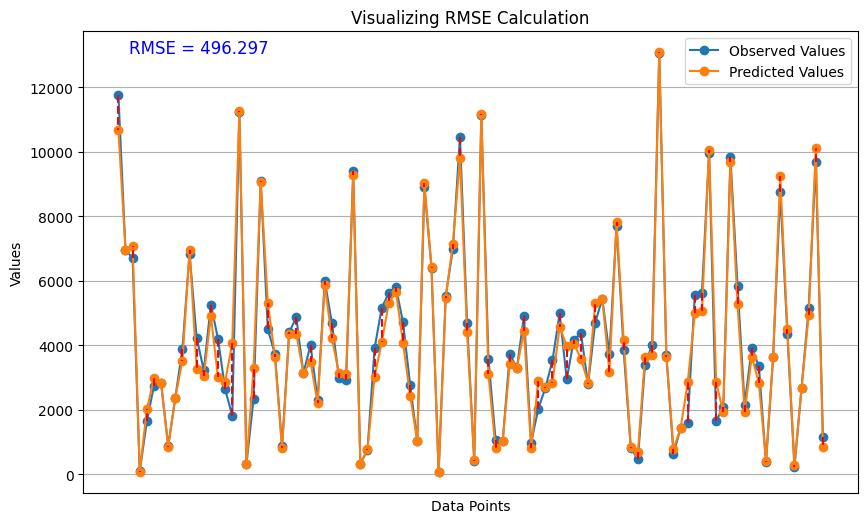

In [12]:
random_indices = np.random.choice(X_test.index, size=100, replace=False)

X_test_sampled = X_test.loc[random_indices]
y_test_sampled = y_test.loc[random_indices]

y_pred_sampled = model.predict(X_test_sampled)

plot_rmse(observed=np.array(y_test_sampled), predicted=np.array(y_pred_sampled), show_error=False)

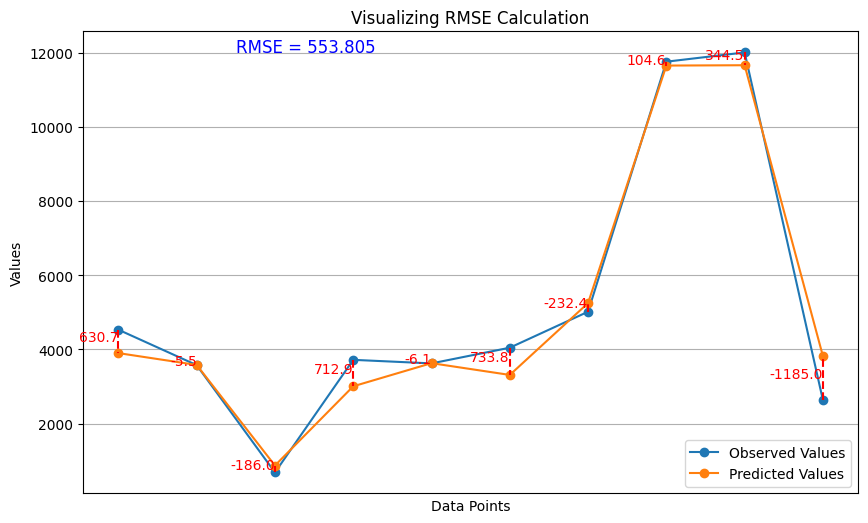

In [13]:
random_indices = np.random.choice(X_test.index, size=10, replace=False)

X_test_sampled = X_test.loc[random_indices]
y_test_sampled = y_test.loc[random_indices]

y_pred_sampled = model.predict(X_test_sampled)

plot_rmse(observed=np.array(y_test_sampled), predicted=np.array(y_pred_sampled), show_error=True)